<a href="https://colab.research.google.com/github/Fxf28/project-capstone/blob/main/capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import os
from pathlib import Path
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import math
import random
from tqdm import tqdm
import cv2
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

## Load Dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizfajar28","key":"f7fd442caa4184f869b5a7fd161e6ddc"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download joebeachcapital/realwaste
!unzip realwaste.zip

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  realwaste.zip
  inflating: realwaste-main/README.md  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_109.jpg 

## Data Preparation

### List jumlah label dan gambar

In [4]:
def list_image_folders(
    dataset_path: str = "path_datasetmu/",
    check_images: bool = True,
    min_images: int = 1
) -> List[Tuple[str, int]]:
    """
    Mencetak daftar folder dalam direktori dataset dengan informasi lengkap

    Parameters:
    - dataset_path: Path ke direktori dataset
    - check_images: Cek keberadaan file gambar dalam folder
    - min_images: Minimal jumlah gambar untuk ditampilkan

    Returns:
    - List of tuples (folder_name, image_count)
    """
    path = Path(dataset_path)

    # Validasi path secara detail
    if not path.exists():
        raise FileNotFoundError(f"Error: Direktori '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"Error: '{dataset_path}' bukan direktori")

    # Dapatkan daftar folder dengan Path
    folders = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for entry in path.iterdir():
        if entry.is_dir():
            if check_images:
                # Hitung file gambar dalam folder
                image_count = sum(
                    1 for f in entry.iterdir()
                    if f.is_file() and f.suffix.lower() in valid_extensions
                )
            else:
                image_count = -1  # Flag untuk pengecekan disabled

            if image_count >= min_images:
                folders.append((entry.name, image_count))

    # Urutkan berdasarkan nama folder
    folders.sort(key=lambda x: x[0].lower())

    # Tampilkan output formatting
    if not folders:
        print("Tidak ada folder dengan gambar yang ditemukan")
        return []

    print(f"Ditemukan {len(folders)} folder di '{path.absolute()}':")
    max_name_length = max(len(f[0]) for f in folders)
    count_total = 0
    for i, (folder, count) in enumerate(folders, start=1):
        count_info = f"({count} gambar)" if check_images else ""
        print(f"{i:2d}. {folder:{max_name_length}} {count_info}")
        count_total += count

    print(f"Jumlah Gambar {count_total}")
    return folders

In [5]:
if __name__ == "__main__":
    folders_info = list_image_folders(
        dataset_path="realwaste-main/RealWaste",
        check_images=True,
        min_images=5
    )

    # Untuk mendapatkan daftar folder saja
    folder_names = [f[0] for f in folders_info]
    print("\nDaftar folder tersedia:", folder_names)

Ditemukan 9 folder di '/content/realwaste-main/RealWaste':
 1. Cardboard           (461 gambar)
 2. Food Organics       (411 gambar)
 3. Glass               (420 gambar)
 4. Metal               (790 gambar)
 5. Miscellaneous Trash (495 gambar)
 6. Paper               (500 gambar)
 7. Plastic             (921 gambar)
 8. Textile Trash       (318 gambar)
 9. Vegetation          (436 gambar)
Jumlah Gambar 4752

Daftar folder tersedia: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


### Cek Resolusi

In [6]:
def get_resolution_summary(dataset_path: str = "path_datasetmu/"):
    """
    Menganalisis resolusi gambar dalam semua sub-direktori (kelas)
    dan menghasilkan ringkasan resolusi untuk seluruh dataset.

    Args:
        base_dir (str): Path ke direktori utama dataset.

    Returns:
        None: Mencetak ringkasan resolusi untuk seluruh dataset.
    """
    resolutions = {}
    total_images = 0
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                try:
                    with Image.open(filepath) as img:
                        width, height = img.size
                        resolution = (width, height)
                        resolutions[resolution] = resolutions.get(resolution, 0) + 1
                        total_images += 1
                except Exception as e:
                    print(f"Gagal membuka atau membaca gambar: {filepath} - {e}")

    unique_resolutions = set(resolutions.keys())
    print(f"Resolusi yang ditemukan: {unique_resolutions}")

    if len(unique_resolutions) == 1:
        for res in unique_resolutions:
            print(f"Semua gambar memiliki resolusi yang seragam: {res}")
    else:
        print("Resolusi tidak seragam.")

    print("\nJumlah gambar per resolusi:")
    for resolution, count in sorted(resolutions.items()):
        print(f"Resolusi {resolution}: {count} gambar")

In [7]:
get_resolution_summary(dataset_path="realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 4752 gambar


### Plot Sample

In [8]:
def plot_category_samples(
    dataset_path: str = "path_datasetmu/",
    samples_per_category: int = 5,
    figsize: tuple = (14, 6),
    label_fontsize: int = 12,
    dpi: int = 100
) -> plt.Figure:
    """
    Memvisualisasikan sampel gambar dari setiap kategori dalam dataset

    Parameters:
    - dataset_path: Path ke direktori dataset
    - samples_per_category: Jumlah sampel gambar per kategori yang akan ditampilkan
    - figsize: Ukuran figure matplotlib (width, height)
    - label_fontsize: Ukuran font label kategori
    - dpi: Kualitas output gambar

    Returns:
    - matplotlib Figure object
    """
    path = Path(dataset_path)

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Cari kategori dengan gambar
    categories = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    for category_dir in path.iterdir():
        if category_dir.is_dir():
            # Cek file gambar dengan glob
            image_files = list(category_dir.glob('*'))
            if any(f.suffix.lower() in valid_extensions for f in image_files):
                categories.append(category_dir.name)

    categories.sort()

    if not categories:
        print("Tidak ada kategori dengan gambar yang ditemukan")
        return None

    # Setup plot
    n_rows = len(categories)
    n_cols = samples_per_category
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0], figsize[1] + n_rows*0.5),  # Dynamic height
        dpi=dpi,
        gridspec_kw={'wspace':0.05, 'hspace':0.3}
    )

    # Handle single category case
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)

    # Hitung margin kiri berdasarkan panjang nama kategori terpanjang
    max_name_length = max(len(cat) for cat in categories)
    plt.subplots_adjust(left=0.2 + 0.01*max_name_length)

    # Plot gambar untuk setiap kategori
    for row_idx, category in enumerate(categories):
        category_path = path / category
        image_files = [
            f for f in category_path.iterdir()
            if f.is_file() and f.suffix.lower() in valid_extensions
        ]

        # Pilih sampel acak dengan jaminan unique
        selected_images = []
        if len(image_files) > 0:
            n_samples = min(samples_per_category, len(image_files))
            selected_indices = np.random.choice(len(image_files), n_samples, replace=False)
            selected_images = [image_files[i] for i in selected_indices]

        # Inisialisasi subplots
        for col_idx in range(n_cols):
            ax = axs[row_idx, col_idx]
            ax.axis('off')
            ax.set_facecolor('#f0f0f0')  # Warna background netral

            # Jika ada gambar yang valid
            if col_idx < len(selected_images):
                try:
                    img = Image.open(selected_images[col_idx])
                    ax.imshow(img)

                    # Tambah border
                    for spine in ax.spines.values():
                        spine.set_visible(True)
                        spine.set_edgecolor('#808080')
                        spine.set_linewidth(0.5)

                except (UnidentifiedImageError, OSError) as e:
                    self._add_error_text(ax, f"Error: {e}")
            else:
                self._add_error_text(ax, "Tidak ada gambar")

        # Tambah label kategori
        axs[row_idx, 0].text(
            -0.3, 0.5,
            category,
            transform=axs[row_idx, 0].transAxes,
            fontsize=label_fontsize,
            fontweight='bold',
            va='center',
            ha='right',
            bbox=dict(
                boxstyle='round',
                facecolor='white',
                edgecolor='#404040',
                alpha=0.8,
                pad=0.3
            )
        )

    plt.show()
    return fig

def _add_error_text(ax, text: str):
    """Helper untuk menambahkan text error di subplot"""
    ax.text(
        0.5, 0.5,
        text,
        ha='center',
        va='center',
        color='red',
        fontsize=8,
        wrap=True
    )
    ax.set_facecolor('#fff0f0')  # Background merah muda untuk error

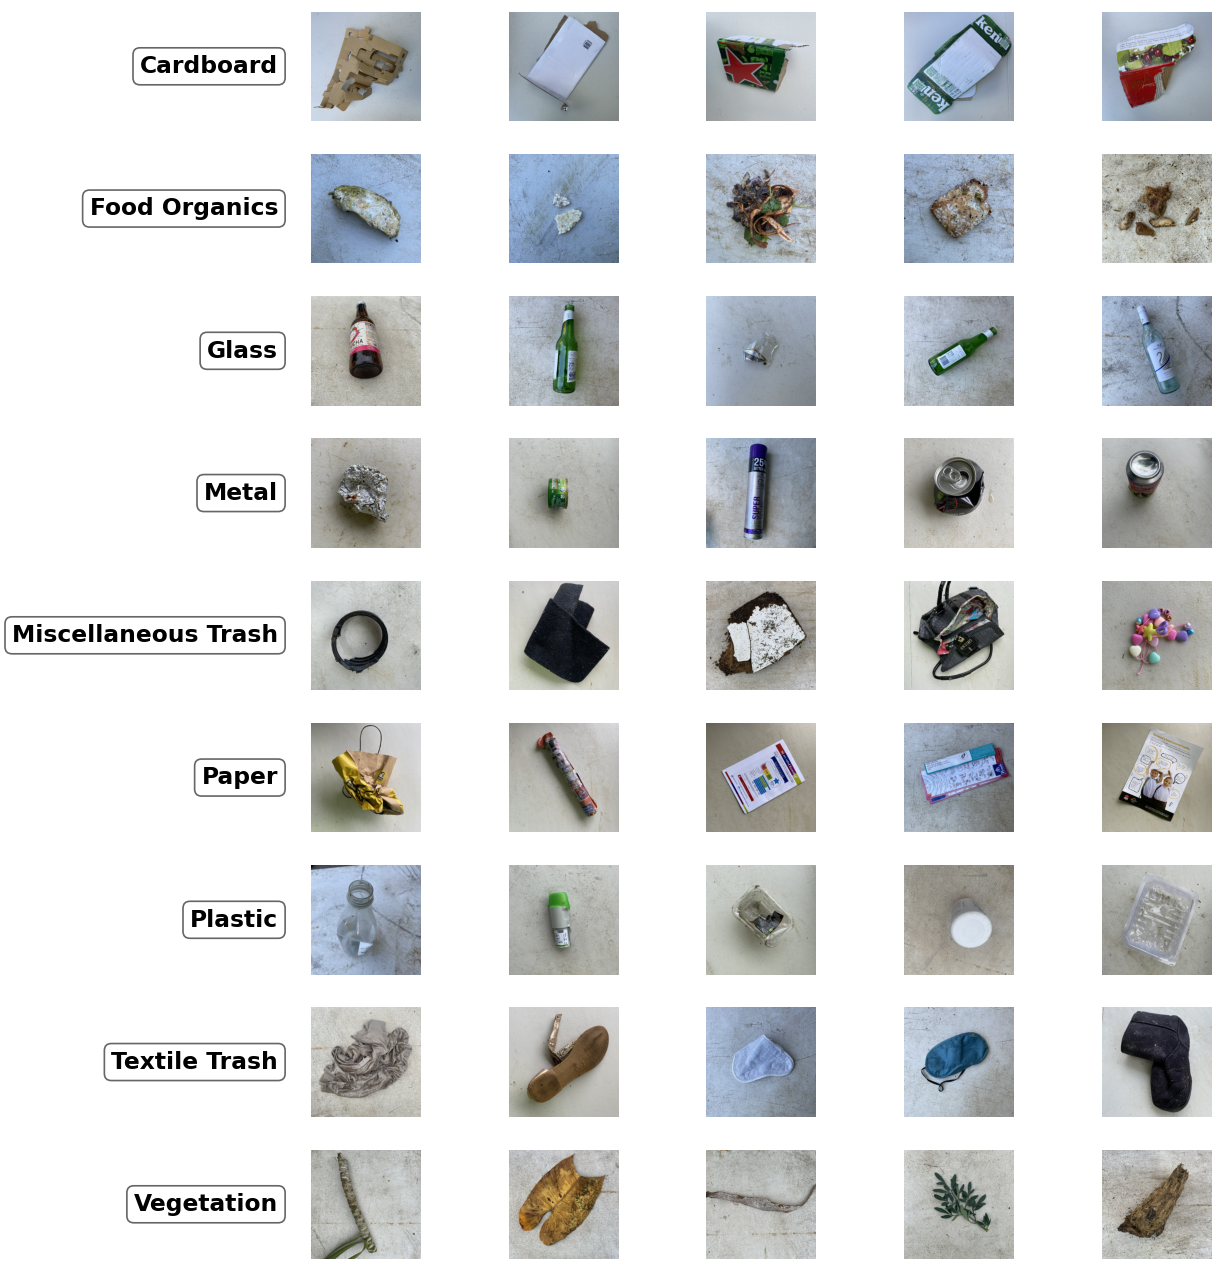

In [9]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="realwaste-main/RealWaste",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

### Distribusi Gambar per Kelas

In [10]:
def analyze_dataset_distribution(dataset_path: str = "path_datasetmy/") -> pd.DataFrame:
    """
    Menganalisis distribusi dataset dan membuat visualisasi

    Parameters:
    - dataset_path: Path ke direktori dataset

    Returns:
    - DataFrame berisi metadata dataset
    """
    path = Path(dataset_path)
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}

    # Validasi path
    if not path.exists():
        raise FileNotFoundError(f"Dataset path '{dataset_path}' tidak ditemukan")
    if not path.is_dir():
        raise NotADirectoryError(f"'{dataset_path}' bukan direktori")

    # Kumpulkan data dengan pathlib
    image_data = []
    for img_path in path.rglob('*'):
        if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
            relative_path = img_path.relative_to(path)
            label = relative_path.parts[0]  # Ambil direktori level pertama
            image_data.append({
                "path": str(img_path),
                "file_name": img_path.name,
                "label": label,
                "extension": img_path.suffix.lower()
            })

    if not image_data:
        raise ValueError("Tidak ditemukan gambar valid dalam dataset")

    df = pd.DataFrame(image_data)

    # Plot distribusi
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(
        data=df,
        y='label',
        hue='label',
        legend=False,
        order=df['label'].value_counts().index,
        palette='viridis'
    )

    # Tambah annotasi
    total_images = len(df)
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f'{int(width)}\n({width/total_images:.1%})',
            (width + 0.1, p.get_y() + p.get_height()/2),
            ha='left',
            va='center'
        )

    plt.title(
        f"Distribusi Dataset - Total {len(df)} Gambar ({len(df['label'].unique())} Kategori)",
        fontsize=14,
        pad=20
    )
    plt.xlabel("Jumlah Gambar", labelpad=15)
    plt.ylabel("Kategori", labelpad=15)
    plt.xlim(0, df['label'].value_counts().max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return df

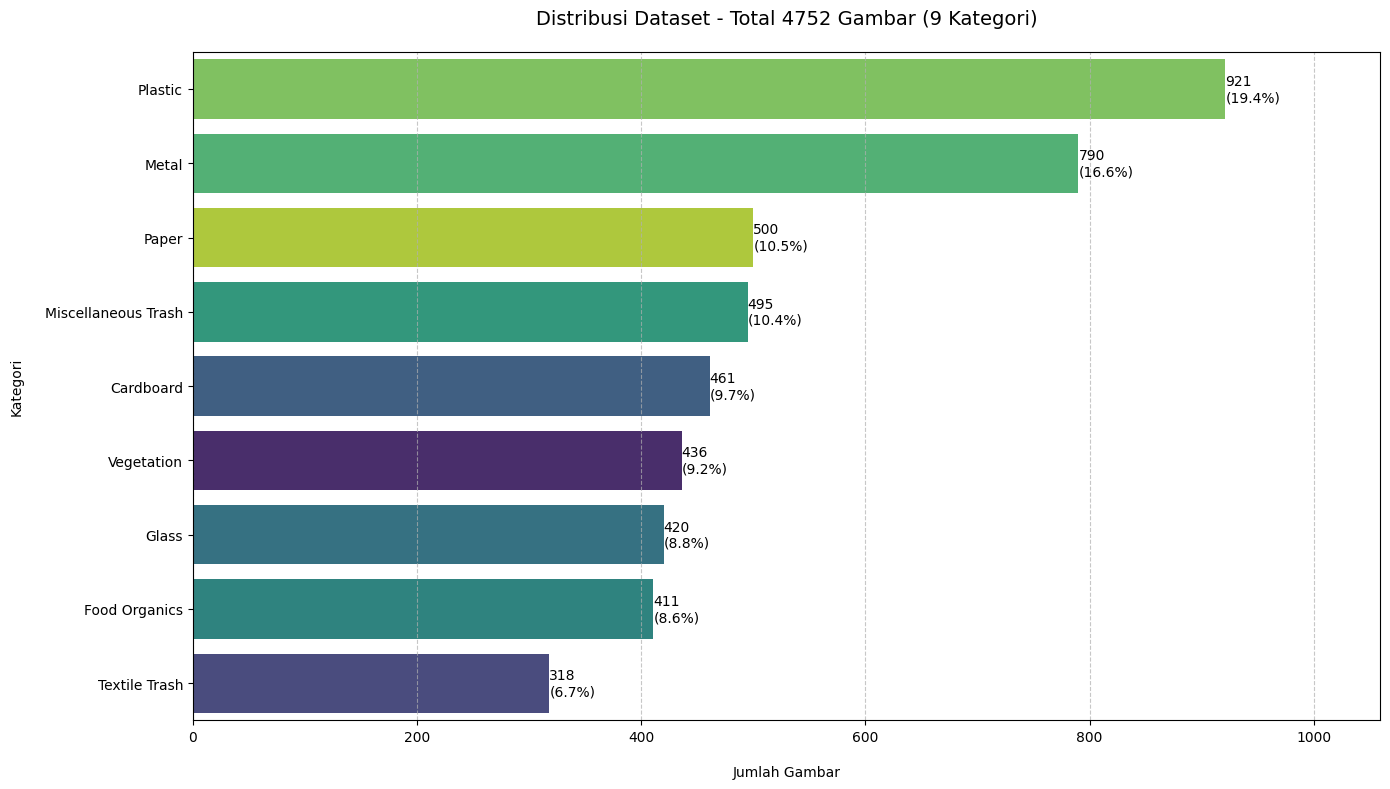


Contoh data:
                                                   path  \
2372  realwaste-main/RealWaste/Miscellaneous Trash/M...   
2540  realwaste-main/RealWaste/Miscellaneous Trash/M...   
206   realwaste-main/RealWaste/Vegetation/Vegetation...   
864   realwaste-main/RealWaste/Cardboard/Cardboard_4...   
3303       realwaste-main/RealWaste/Metal/Metal_542.jpg   

                        file_name                label extension  
2372  Miscellaneous Trash_172.jpg  Miscellaneous Trash      .jpg  
2540  Miscellaneous Trash_354.jpg  Miscellaneous Trash      .jpg  
206            Vegetation_148.jpg           Vegetation      .jpg  
864             Cardboard_421.jpg            Cardboard      .jpg  
3303                Metal_542.jpg                Metal      .jpg  


In [11]:
if __name__ == "__main__":
    dataset_df = analyze_dataset_distribution(
        dataset_path="realwaste-main/RealWaste/"
    )
    print("\nContoh data:")
    print(dataset_df.sample(5))

## Data Augmentation

Target Augmentasi 1000 gambar per kelas(total 9000)

In [12]:
class Augmentor:
    def __init__(self, target_count=1000):
        self.target_count = target_count
        self.augmentations = [
            self.random_brightness,
            self.random_contrast,
            self.random_noise,
            self.flip_lr,
            self.flip_ud,
            self.random_crop_zoom
        ]

    def random_brightness(self, img):
        return tf.image.random_brightness(img, max_delta=0.2, seed=42)

    def random_contrast(self, img):
        return tf.image.random_contrast(img, lower=0.5, upper=1.5, seed=42)

    def random_noise(self, img):
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, dtype=tf.float32, seed=42)
        noisy_img = img + noise
        return tf.clip_by_value(noisy_img, 0.0, 1.0)

    def flip_lr(self, img):
        return tf.image.random_flip_left_right(img, seed=42)

    def flip_ud(self, img):
        return tf.image.random_flip_up_down(img, seed=42)

    def random_crop_zoom(self, img):
        cropped = tf.image.central_crop(img, central_fraction=0.9)
        return tf.image.resize(cropped, [524, 524])

    def augment_image(self, img):
        random.shuffle(self.augmentations)
        for aug_fn in self.augmentations[:random.randint(1, 3)]:
            img = aug_fn(img)
        return tf.clip_by_value(img, 0.0, 1.0)

def balance_dataset(
    input_dir="realwaste-main/RealWaste/",
    output_dir="realwaste-main/RealWaste/",
    target_count=1000
):
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    for class_dir in input_path.iterdir():
        if not class_dir.is_dir() or "_aug" in class_dir.name:
            continue

        class_name = class_dir.name
        output_class_dir = output_path / f"{class_name}_aug"
        output_class_dir.mkdir(parents=True, exist_ok=True)

        original_images = list(class_dir.glob("*.*"))
        original_count = len(original_images)
        needed = target_count - original_count

        if needed <= 0:
            print(f"\nKelas {class_name} sudah cukup: {original_count} gambar")
            shutil.rmtree(output_class_dir)
            continue

        print(f"\nKelas {class_name}_aug:")
        print(f"Original: {original_count} | Butuh: {needed} augmentasi")
        print(f"Augmentasi per gambar: {math.ceil(needed/original_count)}x")

        augmentor = Augmentor(target_count)
        generated = 0

        with tqdm(total=needed, desc="Memproses") as pbar:
            for img_path in original_images:
                try:
                    img = cv2.imread(str(img_path))
                    img = cv2.resize(img, (524, 524)).astype(np.float32) / 255.0
                    img_tensor = tf.expand_dims(tf.convert_to_tensor(img), -1)

                    for _ in range(math.ceil(needed/original_count)):
                        if generated >= needed:
                            break

                        augmented = augmentor.augment_image(img_tensor).numpy().squeeze()
                        augmented = (augmented * 255).astype(np.uint8)

                        cv2.imwrite(
                            str(output_class_dir / f"aug_{class_name}_{generated}{img_path.suffix}"),
                            augmented
                        )
                        generated += 1
                        pbar.update(1)

                except Exception as e:
                    print(f"\nError: {img_path.name} - {str(e)}")

        print(f"\nJumlah Gambar Augmentasi: {len(list(output_class_dir.glob('*.*')))} gambar")
        print("="*50)

In [13]:
if __name__ == "__main__":
    balance_dataset()


Kelas Vegetation_aug:
Original: 436 | Butuh: 564 augmentasi
Augmentasi per gambar: 2x


Memproses: 100%|██████████| 564/564 [02:53<00:00,  3.26it/s]



Jumlah Gambar Augmentasi: 386 gambar

Kelas Textile Trash_aug:
Original: 318 | Butuh: 682 augmentasi
Augmentasi per gambar: 3x


Memproses: 100%|██████████| 682/682 [03:30<00:00,  3.24it/s]



Jumlah Gambar Augmentasi: 455 gambar

Kelas Cardboard_aug:
Original: 461 | Butuh: 539 augmentasi
Augmentasi per gambar: 2x


Memproses: 100%|██████████| 539/539 [02:54<00:00,  3.09it/s]



Jumlah Gambar Augmentasi: 353 gambar

Kelas Glass_aug:
Original: 420 | Butuh: 580 augmentasi
Augmentasi per gambar: 2x


Memproses: 100%|██████████| 580/580 [03:03<00:00,  3.15it/s]



Jumlah Gambar Augmentasi: 383 gambar

Kelas Food Organics_aug:
Original: 411 | Butuh: 589 augmentasi
Augmentasi per gambar: 2x


Memproses: 100%|██████████| 589/589 [03:14<00:00,  3.02it/s]



Jumlah Gambar Augmentasi: 381 gambar

Kelas Miscellaneous Trash_aug:
Original: 495 | Butuh: 505 augmentasi
Augmentasi per gambar: 2x


Memproses: 100%|██████████| 505/505 [02:25<00:00,  3.47it/s]



Jumlah Gambar Augmentasi: 350 gambar

Kelas Metal_aug:
Original: 790 | Butuh: 210 augmentasi
Augmentasi per gambar: 1x


Memproses: 100%|██████████| 210/210 [01:11<00:00,  2.92it/s]



Jumlah Gambar Augmentasi: 136 gambar

Kelas Plastic_aug:
Original: 921 | Butuh: 79 augmentasi
Augmentasi per gambar: 1x


Memproses: 100%|██████████| 79/79 [00:18<00:00,  4.18it/s]



Jumlah Gambar Augmentasi: 64 gambar

Kelas Paper_aug:
Original: 500 | Butuh: 500 augmentasi
Augmentasi per gambar: 1x


Memproses: 100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


Jumlah Gambar Augmentasi: 322 gambar


### Validasi Augmentasi

In [14]:
if __name__ == "__main__":
    folders_info = list_image_folders(
        dataset_path="realwaste-main/RealWaste",
        check_images=True,
        min_images=5
    )

    # Untuk mendapatkan daftar folder saja
    folder_names = [f[0] for f in folders_info]
    print("\nDaftar folder tersedia:", folder_names)

Ditemukan 18 folder di '/content/realwaste-main/RealWaste':
 1. Cardboard               (461 gambar)
 2. Cardboard_aug           (353 gambar)
 3. Food Organics           (411 gambar)
 4. Food Organics_aug       (381 gambar)
 5. Glass                   (420 gambar)
 6. Glass_aug               (383 gambar)
 7. Metal                   (790 gambar)
 8. Metal_aug               (136 gambar)
 9. Miscellaneous Trash     (495 gambar)
10. Miscellaneous Trash_aug (350 gambar)
11. Paper                   (500 gambar)
12. Paper_aug               (322 gambar)
13. Plastic                 (921 gambar)
14. Plastic_aug             (64 gambar)
15. Textile Trash           (318 gambar)
16. Textile Trash_aug       (455 gambar)
17. Vegetation              (436 gambar)
18. Vegetation_aug          (386 gambar)
Jumlah Gambar 7582

Daftar folder tersedia: ['Cardboard', 'Cardboard_aug', 'Food Organics', 'Food Organics_aug', 'Glass', 'Glass_aug', 'Metal', 'Metal_aug', 'Miscellaneous Trash', 'Miscellaneous Trash_au

In [15]:
get_resolution_summary(dataset_path="realwaste-main/RealWaste")

Resolusi yang ditemukan: {(524, 524)}
Semua gambar memiliki resolusi yang seragam: (524, 524)

Jumlah gambar per resolusi:
Resolusi (524, 524): 7582 gambar


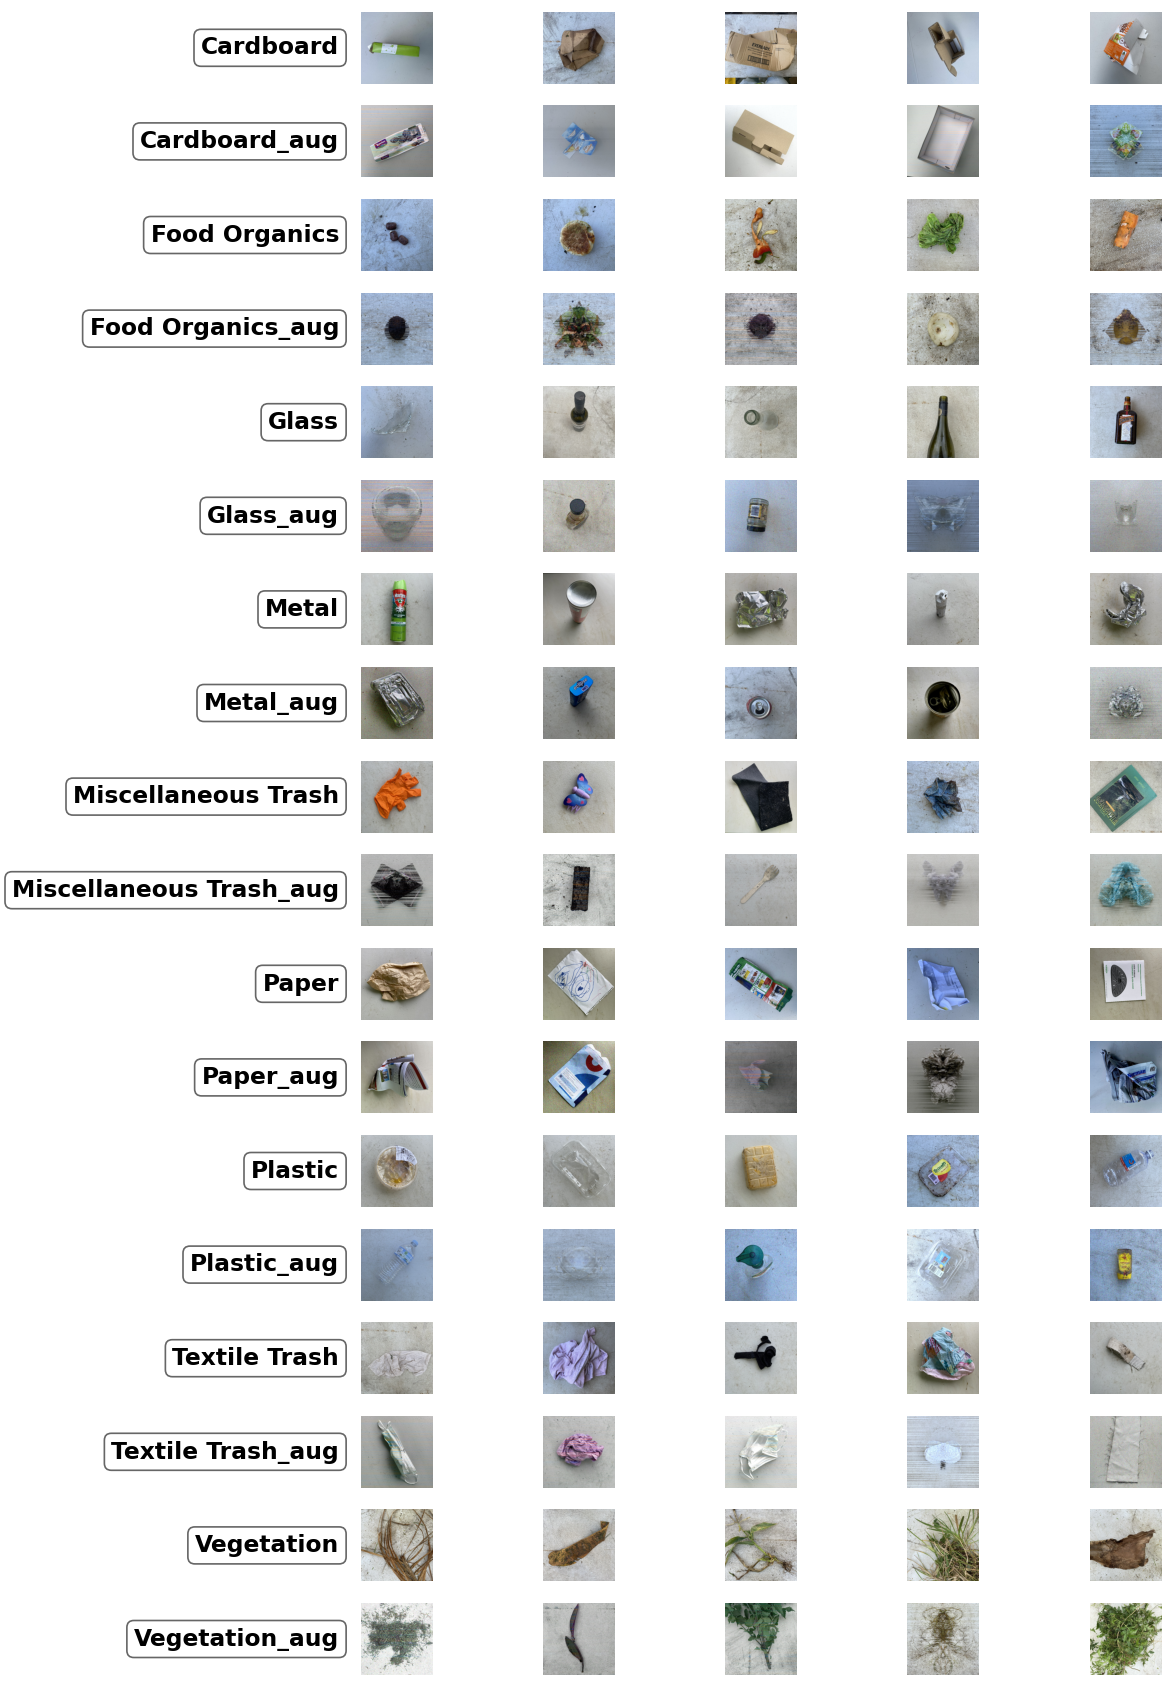

In [16]:
if __name__ == "__main__":
    fig = plot_category_samples(
        dataset_path="realwaste-main/RealWaste",
        samples_per_category=5,
        figsize=(16, 9),
        label_fontsize=14,
        dpi=120
    )

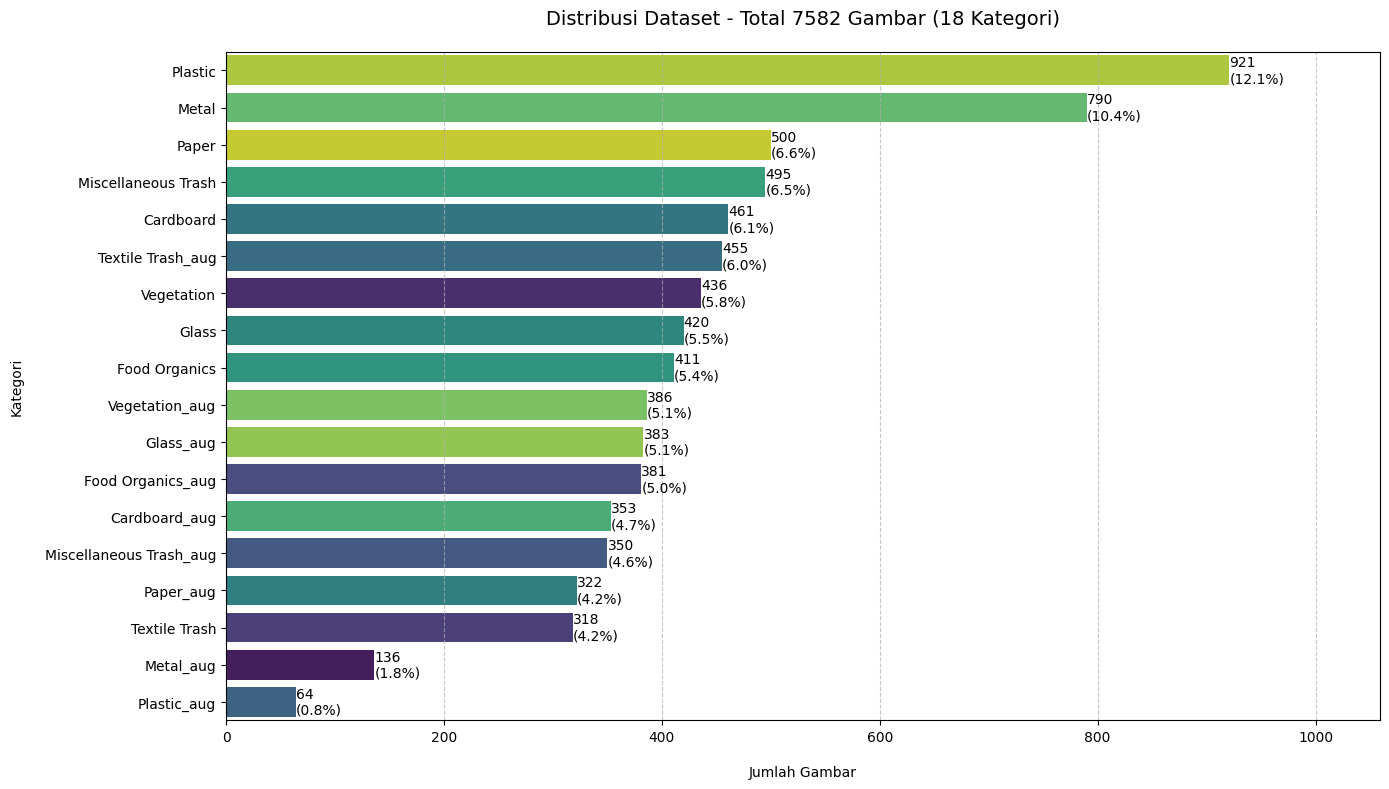


Contoh data:
                                                   path  \
985   realwaste-main/RealWaste/Food Organics_aug/aug...   
591   realwaste-main/RealWaste/Textile Trash/Textile...   
1863  realwaste-main/RealWaste/Textile Trash_aug/aug...   
3232       realwaste-main/RealWaste/Glass/Glass_111.jpg   
4542  realwaste-main/RealWaste/Cardboard_aug/aug_Car...   

                      file_name              label extension  
985   aug_Food Organics_538.jpg  Food Organics_aug      .jpg  
591       Textile Trash_218.jpg      Textile Trash      .jpg  
1863  aug_Textile Trash_353.jpg  Textile Trash_aug      .jpg  
3232              Glass_111.jpg              Glass      .jpg  
4542      aug_Cardboard_325.jpg      Cardboard_aug      .jpg  


In [17]:
if __name__ == "__main__":
    dataset_df = analyze_dataset_distribution(
        dataset_path="realwaste-main/RealWaste/"
    )
    print("\nContoh data:")
    print(dataset_df.sample(5))

## Data Preparation

Data splitting train val test

In [18]:
def create_split_dataframe(
    input_dir="realwaste-main/RealWaste/",
    output_dir="dataset_split",
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
):
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    # Buat direktori utama
    splits = ['train', 'val', 'test']
    for split in splits:
        (output_path/split).mkdir(parents=True, exist_ok=True)

    dataframe = []

    for class_dir in input_path.iterdir():
        if not class_dir.is_dir():
            continue

        class_name = class_dir.name.replace("_aug", "")
        print(f"\nProcessing class: {class_name}")

        # Baca semua gambar original dan augmented
        original_images = list((input_path/class_name).glob("*.*"))
        augmented_images = list((input_path/f"{class_name}_aug").glob("*.*")) if (input_path/f"{class_name}_aug").exists() else []

        # Split original images
        random.shuffle(original_images)
        total_original = len(original_images)

        # Hitung jumlah split
        val_size = math.floor(total_original * val_ratio)
        test_size = math.floor(total_original * test_ratio)
        train_size = total_original - val_size - test_size

        # Split dataset
        train_images = original_images[:train_size]
        val_images = original_images[train_size:train_size+val_size]
        test_images = original_images[train_size+val_size:]

        # Proses semua gambar
        print("Memproses split dataset...")

        # Salin original images ke split folders
        for split, images in zip(splits, [train_images, val_images, test_images]):
            split_dir = output_path/split/class_name
            split_dir.mkdir(exist_ok=True)

            for img_path in tqdm(images, desc=f"Original {split}"):
                shutil.copy(img_path, split_dir/img_path.name)
                dataframe.append({
                    'filepath': str(split_dir/img_path.name),
                    'label': class_name,
                    'split': split,
                    'augmented': False
                })

        # Salin augmented images ke train folder
        if augmented_images:
            train_dir = output_path/'train'/class_name
            train_dir.mkdir(exist_ok=True)

            for img_path in tqdm(augmented_images, desc="Augmented"):
                shutil.copy(img_path, train_dir/img_path.name)
                dataframe.append({
                    'filepath': str(train_dir/img_path.name),
                    'label': class_name,
                    'split': 'train',
                    'augmented': True
                })

    # Simpan dataframe
    df = pd.DataFrame(dataframe)
    df.to_csv(output_path/'dataset_info.csv', index=False)
    print("\nDataframe berhasil disimpan di:", output_path/'dataset_info.csv')
    return df

In [19]:
if __name__ == "__main__":
    create_split_dataframe()


Processing class: Metal
Memproses split dataset...


Augmented: 100%|██████████| 136/136 [00:00<00:00, 2814.75it/s]



Processing class: Vegetation
Memproses split dataset...


Augmented: 100%|██████████| 386/386 [00:00<00:00, 2044.63it/s]



Processing class: Textile Trash
Memproses split dataset...


Augmented: 100%|██████████| 455/455 [00:00<00:00, 1661.37it/s]



Processing class: Food Organics
Memproses split dataset...


Augmented: 100%|██████████| 381/381 [00:00<00:00, 1164.70it/s]



Processing class: Miscellaneous Trash
Memproses split dataset...


Augmented: 100%|██████████| 350/350 [00:00<00:00, 1432.51it/s]



Processing class: Plastic
Memproses split dataset...


Augmented: 100%|██████████| 64/64 [00:00<00:00, 4238.54it/s]



Processing class: Textile Trash
Memproses split dataset...


Augmented: 100%|██████████| 455/455 [00:00<00:00, 2676.18it/s]



Processing class: Cardboard
Memproses split dataset...


Augmented: 100%|██████████| 353/353 [00:00<00:00, 1546.38it/s]



Processing class: Paper
Memproses split dataset...


Augmented: 100%|██████████| 322/322 [00:00<00:00, 1004.15it/s]



Processing class: Glass
Memproses split dataset...


Augmented: 100%|██████████| 383/383 [00:00<00:00, 3639.67it/s]



Processing class: Food Organics
Memproses split dataset...


Augmented: 100%|██████████| 381/381 [00:00<00:00, 2263.23it/s]



Processing class: Miscellaneous Trash
Memproses split dataset...


Augmented: 100%|██████████| 350/350 [00:00<00:00, 1842.19it/s]



Processing class: Cardboard
Memproses split dataset...


Augmented: 100%|██████████| 353/353 [00:00<00:00, 2619.78it/s]



Processing class: Metal
Memproses split dataset...


Augmented: 100%|██████████| 136/136 [00:00<00:00, 1108.78it/s]



Processing class: Vegetation
Memproses split dataset...


Augmented: 100%|██████████| 386/386 [00:00<00:00, 2384.48it/s]



Processing class: Glass
Memproses split dataset...


Augmented: 100%|██████████| 383/383 [00:00<00:00, 2739.26it/s]



Processing class: Plastic
Memproses split dataset...


Augmented: 100%|██████████| 64/64 [00:00<00:00, 2650.56it/s]



Processing class: Paper
Memproses split dataset...


Augmented: 100%|██████████| 322/322 [00:00<00:00, 1353.66it/s]


Dataframe berhasil disimpan di: dataset_split/dataset_info.csv


### Image Data Generator

In [31]:
# Path direktori
TRAIN_DIR = "dataset_split/train"
VAL_DIR = "dataset_split/val"
TEST_DIR = "dataset_split/test"

# Generator dengan penyesuaian untuk grayscale
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=42  # Tambahkan seed untuk reproducibility
)

# Generator untuk validasi
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)

Found 8813 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Found 894 images belonging to 9 classes.


In [32]:
for x, y in train_generator:
    print(f"Input shape: {x.shape}")
    print(f"Label shape: {y.shape}")
    break

Input shape: (32, 224, 224, 3)
Label shape: (32, 9)


In [33]:
print("Train classes:", train_generator.class_indices)
print("Validation classes:", validation_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Train classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}
Validation classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}
Test classes: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


## Pemodelan

In [34]:
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

def build_model():
    model = Sequential(name="LightDigitCNN")

    # Blok Konvolusi 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))

    # Blok Konvolusi 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.4))

    # Blok Feature Extraction
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    # Opsional: 1x1 convolution untuk pencampuran channel tanpa menambah banyak parameter
    model.add(Conv2D(128, (1,1), activation='relu', padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Inisialisasi model
model = build_model()
model.summary()

Model: "LightDigitCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,993 (617.16 KB)

 Trainable params: 157,545 (615.41 KB)

 Non-trainable params: 448 (1.75 KB)

In [35]:
optimizer = Adam(learning_rate=1e-3)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [36]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

In [37]:
# Training model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 211ms/step - accuracy: 0.2612 - loss: 2.1977 - precision: 0.3398 - recall: 0.1055 - val_accuracy: 0.1033 - val_loss: 2.8740 - val_precision: 0.1694 - val_recall: 0.0700 - learning_rate: 0.0010
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 46s 167ms/step - accuracy: 0.3953 - loss: 1.6936 - precision: 0.5471 - recall: 0.1962 - val_accuracy: 0.2856 - val_loss: 2.4224 - val_precision: 0.3776 - val_recall: 0.1989 - learning_rate: 0.0010
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 166ms/step - accuracy: 0.4591 - loss: 1.5119 - precision: 0.6467 - recall: 0.2619 - val_accuracy: 0.3022 - val_loss: 2.1309 - val_precision: 0.4024 - val_recall: 0.1856 - learning_rate: 0.0010
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.5167 - loss: 1.3607 - precision: 0.6965 - recall: 0.3161 - val_accuracy: 0.3989 - val_loss: 1.8281 - val_precision: 0.4508 - val_recall: 0.3056 - learning_rate: 0.0010
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 47s 172ms/st

KeyboardInterrupt: 

### Evaluasi

## Konversi Model

## Inferensi